In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

In [3]:
import re
from wordcloud import WordCloud, STOPWORDS 

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [5]:
import statsmodels.api as sm

In [6]:
spy=pd.read_csv('spy.csv')

In [7]:
spy['date']=pd.to_datetime(spy['timestamp']).dt.date
spy_holding=spy.groupby(['date'])['users_holding'].sum().reset_index()
spy_holding['date'] = pd.to_datetime(spy_holding['date'])  
mask = (spy_holding['date'] >= '2020-02-01') & (spy_holding['date'] <= '2020-07-01')
spy_holding=spy_holding.loc[mask]

In [8]:
spx=pd.read_csv('spx.csv')

In [9]:
spx['Date']=pd.to_datetime(spx.Date)

In [10]:
spx.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-03,2885.379883,2911.129883,2855.939941,2910.629883,2910.629883,3503640000
1,2019-10-04,2918.560059,2953.739990,2918.560059,2952.010010,2952.010010,2990830000
2,2019-10-07,2944.229980,2959.750000,2935.679932,2938.790039,2938.790039,2940140000
3,2019-10-08,2920.399902,2925.469971,2892.659912,2893.060059,2893.060059,3356450000
4,2019-10-09,2911.100098,2929.320068,2907.409912,2919.399902,2919.399902,2726820000


In [11]:
headline=pd.read_csv('covid_headline_0201_0702.csv',error_bad_lines=False)

b'Skipping line 58426: expected 8 fields, saw 9\n'
b'Skipping line 98836: expected 8 fields, saw 10\n'
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
headline.drop(['id','description','link','source_link','crawled'],axis=1,inplace=True)

In [13]:
#plot top news source
source_list=headline.groupby(['source'])['title'].count().sort_values(ascending=False).index

In [14]:
#remove the news headlines without proper source
headline=headline[headline['source'].isin(list(source_list[:-12]))]

In [15]:
#remove news that're published before 2020-01-31
headline=headline[headline.published_date>'2020-01-31 00:00:00']

In [16]:
#convert to datetime format
headline['published_timestamp']=pd.to_datetime(headline.published_date)
headline['published_date']=pd.to_datetime(headline['published_timestamp'].apply(lambda x: str(x)[:10]))

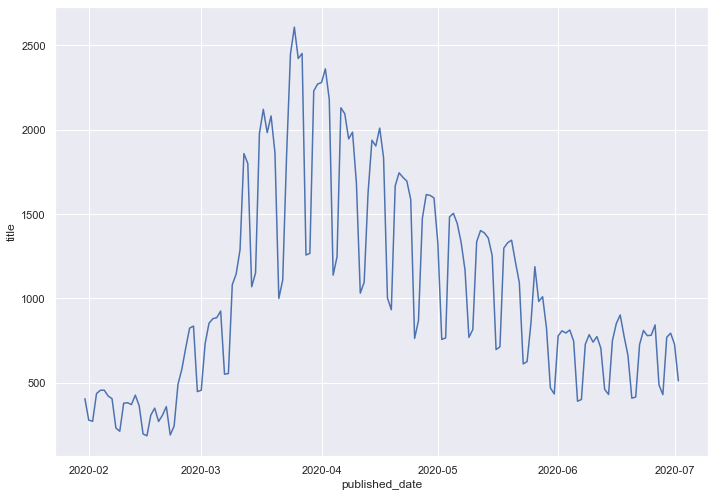

In [17]:
#plot number of news headlines over the entire period
count_by_date=headline.groupby(['published_date'])['title'].count().reset_index()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("darkgrid")
sns.lineplot(data=count_by_date, x="published_date", y="title")

In [49]:
count_by_date=headline.groupby(['published_date'])['title'].count().reset_index()
ols_table=count_by_date.merge(spy_holding,left_on='published_date',right_on='date')
ols_table.head()
ols_table.columns=['date1','news_count','date2','users_holding']
mod = sm.OLS(ols_table.users_holding, ols_table.news_count)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:          users_holding   R-squared (uncentered):                   0.714
Model:                            OLS   Adj. R-squared (uncentered):              0.712
Method:                 Least Squares   F-statistic:                              376.1
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                    7.86e-43
Time:                        20:29:39   Log-Likelihood:                         -2318.4
No. Observations:                 152   AIC:                                      4639.
Df Residuals:                     151   BIC:                                      4642.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

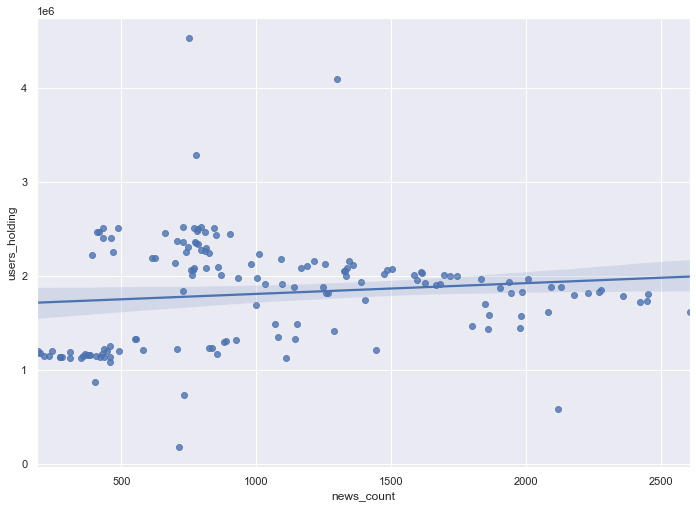

In [74]:
sns.regplot(x="news_count", y="users_holding", data=ols_table);

In [ ]:
mod = sm.OLS(ols_table.users_holding, ols_table.news_count)
res = mod.fit()
print(res.summary())

In [59]:
ols_table.head()

,date1,news_count,date2,users_holding,lockdown
0,2020-02-01,279,2020-02-01,1130502,0
1,2020-02-02,272,2020-02-02,1130472,0
2,2020-02-03,436,2020-02-03,1130922,0
3,2020-02-04,456,2020-02-04,1084177,0
4,2020-02-05,456,2020-02-05,1131991,0


In [61]:
#add lockdown related variables to the ols table
ols_table['lockdown']=0
ols_table['lockdown'].loc[(ols_table['date1']>='2020-03-16')&(ols_table['date1']<='2020-05-07')] = 1
ols_table['lockdown_newscount']=ols_table['news_count']*ols_table['lockdown']

In [69]:
#add log popularity and pct change in holding
ols_table['log_holding']=np.log(ols_table['users_holding'])
ols_table['pct_change_holding']=ols_table['users_holding'].pct_change()

In [79]:
#add lag news count variables
ols_table['count_lag1']=ols_table['news_count'].shift(periods=1)
ols_table['count_lag2']=ols_table['news_count'].shift(periods=2)
ols_table['count_lag3']=ols_table['news_count'].shift(periods=3)

In [67]:
#fit model with log_holding as Y
mod = sm.OLS(ols_table.log_holding, ols_table.news_count)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:            log_holding   R-squared (uncentered):                   0.756
Model:                            OLS   Adj. R-squared (uncentered):              0.754
Method:                 Least Squares   F-statistic:                              467.6
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                    4.28e-48
Time:                        21:28:38   Log-Likelihood:                         -513.48
No. Observations:                 152   AIC:                                      1029.
Df Residuals:                     151   BIC:                                      1032.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

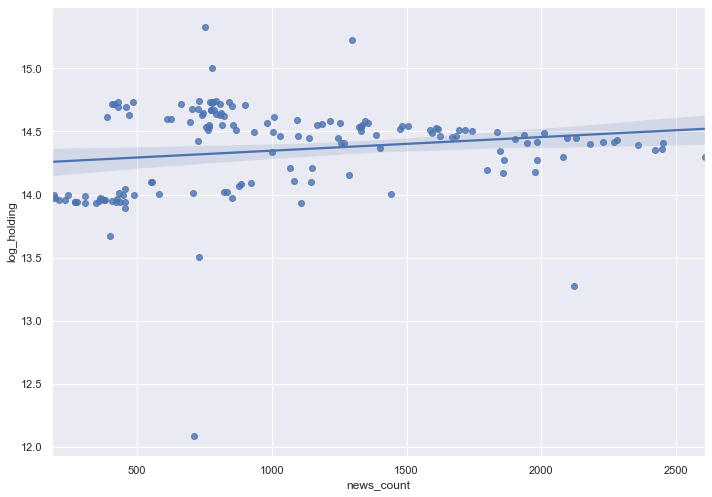

In [72]:
sns.regplot(x="news_count", y="log_holding", data=ols_table);

In [71]:
#fit model with pct change in holding as Y
mod = sm.OLS(ols_table.pct_change_holding[1:], ols_table.news_count[1:])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:     pct_change_holding   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              1.506
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                       0.222
Time:                        21:34:09   Log-Likelihood:                         -303.34
No. Observations:                 151   AIC:                                      608.7
Df Residuals:                     150   BIC:                                      611.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

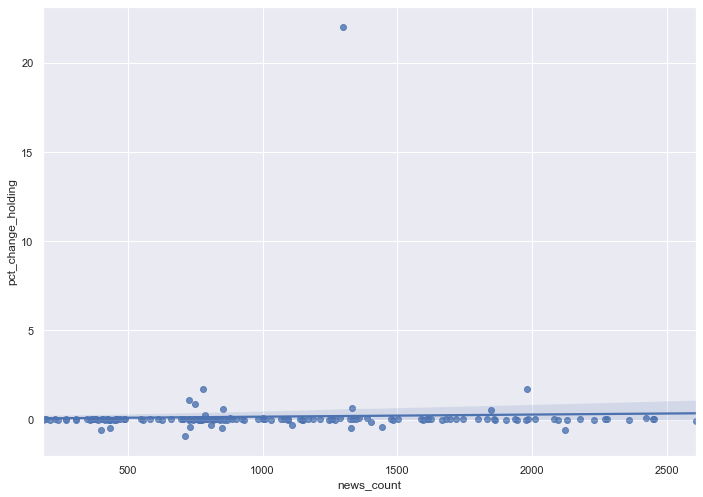

In [73]:
sns.regplot(x="news_count", y="pct_change_holding", data=ols_table);

In [65]:
#model 4.1.2
x=ols_table[['news_count','lockdown','lockdown_newscount']]
y=ols_table['users_holding']
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:          users_holding   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.849
Method:                 Least Squares   F-statistic:                              285.3
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                    1.59e-61
Time:                        20:53:31   Log-Likelihood:                         -2268.3
No. Observations:                 152   AIC:                                      4543.
Df Residuals:                     149   BIC:                                      4552.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [77]:
#model 4.1.2 using log_holding as dependent variable
x=ols_table[['news_count','lockdown','lockdown_newscount']]
y=ols_table['log_holding']
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:            log_holding   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              359.6
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                    5.27e-68
Time:                        21:45:36   Log-Likelihood:                         -460.36
No. Observations:                 152   AIC:                                      926.7
Df Residuals:                     149   BIC:                                      935.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [80]:
#model 4.1.2, adding lag news counts ---looks like lagged news count don't have significnat coefficient
x=ols_table[['news_count','lockdown','lockdown_newscount','count_lag1','count_lag2','count_lag3']]
y=ols_table['log_holding']
mod = sm.OLS(y[3:], x[3:])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:            log_holding   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                              203.8
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                    1.81e-67
Time:                        21:53:18   Log-Likelihood:                         -440.37
No. Observations:                 149   AIC:                                      892.7
Df Residuals:                     143   BIC:                                      910.8
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

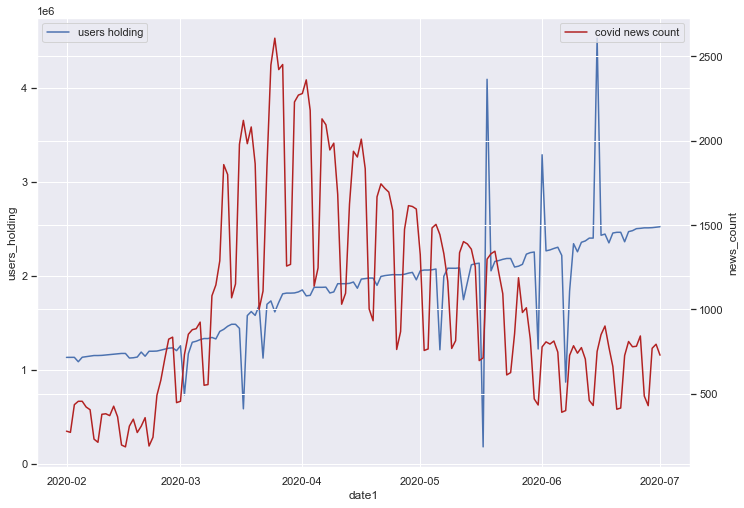

In [20]:
fig, ax = plt.subplots()
sns.lineplot(data=ols_table, x='date1', y='users_holding',label='users holding')
ax2 = ax.twinx()
sns.lineplot(data=ols_table,x='date1',y='news_count',color='firebrick',label='covid news count') 
ax.legend()

In [24]:
def preprocess_title(title):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(title)
    words=[word.lower() for word in words if word.isalnum()]
    filtered_sentence = [w for w in words if not w in stop_words]
    
    return filtered_sentence

In [25]:
headline['title_words']=headline['title'].apply(lambda x: preprocess_title(x))

In [26]:
headline=headline.reset_index()

In [27]:
lst=list(headline['title'].values)
seperator = ' '
text=seperator.join(lst)

In [28]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [29]:
text = re.sub(r'==.*?==+', '', text)
text = text.replace('\n', '')

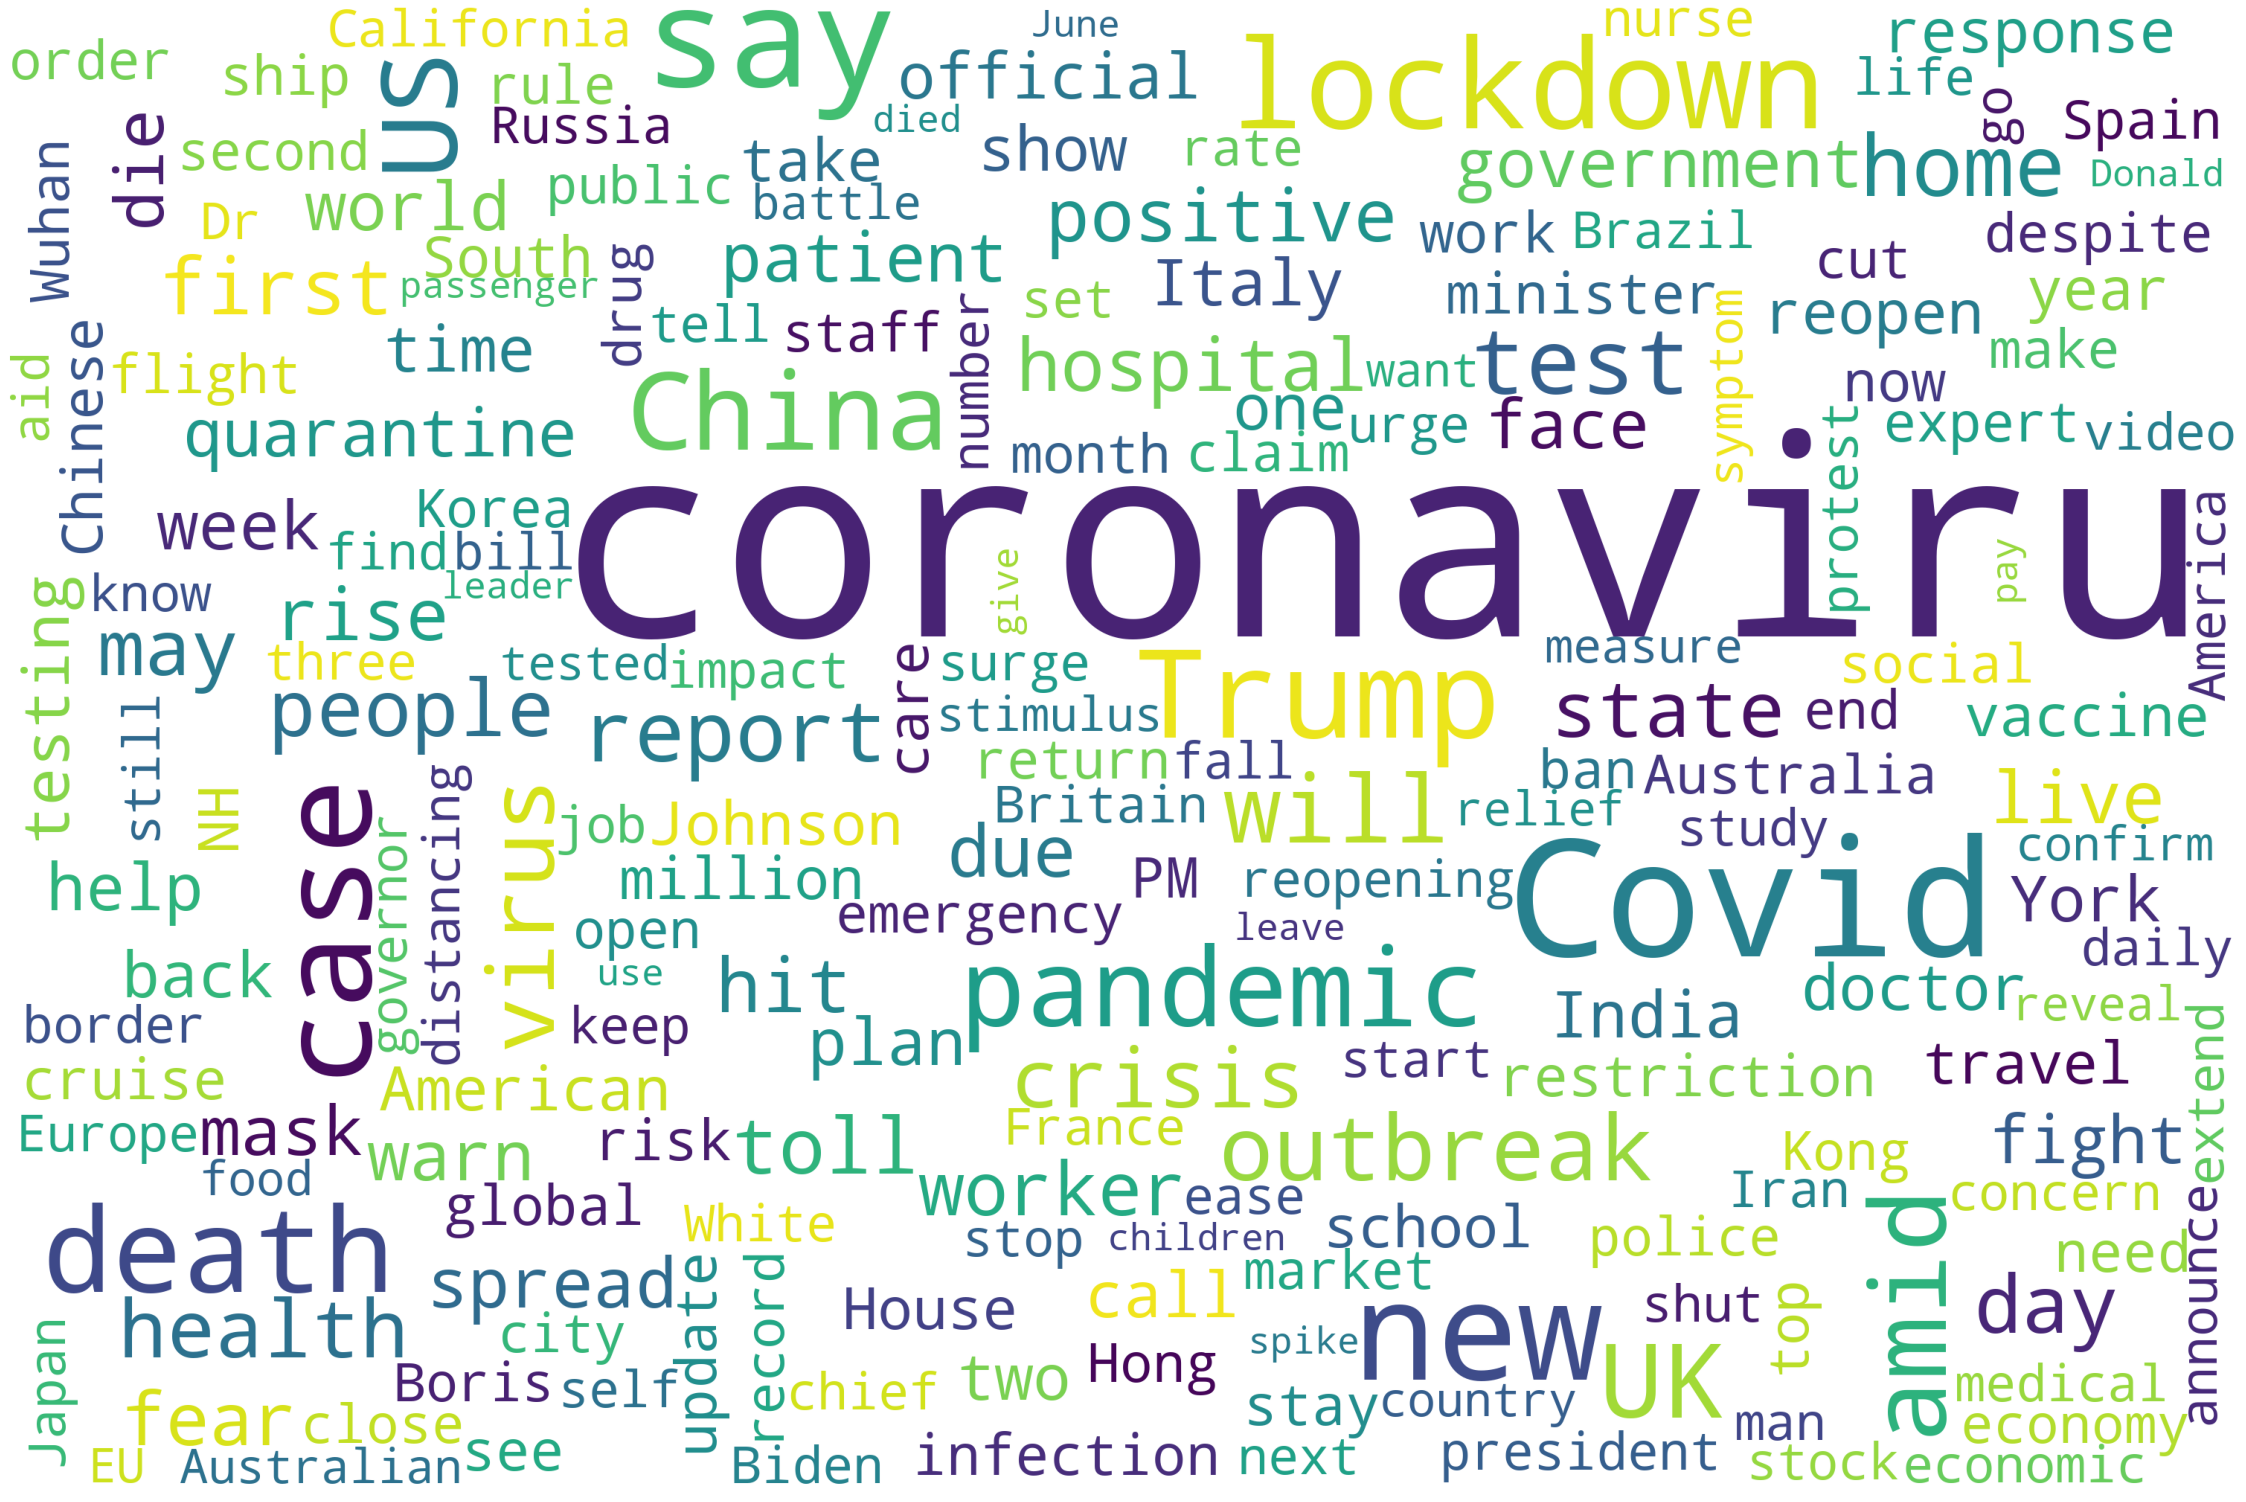

In [30]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', 
                      colormap='viridis', collocations=False, stopwords = STOPWORDS).generate(text)
plot_cloud(wordcloud)

In [31]:
analyzer = SentimentIntensityAnalyzer()
sentiment_df = pd.DataFrame() 
for i in range(len(headline)):
    vs = analyzer.polarity_scores(headline.title[i])
    df_vs=pd.DataFrame({k: [v] for k, v in vs.items()})
    sentiment_df=sentiment_df.append(df_vs)

sentiment_df.head()

,neg,neu,pos,compound
0,0.189,0.811,0.000,-0.4215
0,0.205,0.551,0.244,0.1280
0,0.000,0.757,0.243,0.4391
0,0.000,1.000,0.000,0.0000
0,0.206,0.794,0.000,-0.3818


In [32]:
len(sentiment_df)

161283

In [33]:
len(headline)

161283

In [34]:
headline['neg']=list(sentiment_df['neg'])
headline['neu']=list(sentiment_df['neu'])
headline['pos']=list(sentiment_df['pos'])
headline['compound']=list(sentiment_df['compound'])

In [35]:
headline.head()

,level_0,index,title,source,published_date,published_timestamp,title_words,neg,neu,pos,compound
0,0,0,British coronavirus evacuee who was 'taken ill...,dailymail.co.uk,2020-02-04,2020-02-04 08:09:54,"[british, coronavirus, evacuee, ill, last, fli...",0.189,0.811,0.000,-0.4215
1,1,1,CDC files for emergency approval of its corona...,dailymail.co.uk,2020-02-03,2020-02-03 21:25:50,"[cdc, files, emergency, approval, coronavirus,...",0.205,0.551,0.244,0.1280
2,2,2,Can ANY face mask really protect you from the ...,dailymail.co.uk,2020-02-03,2020-02-03 21:19:39,"[face, mask, really, protect, coronavirus]",0.000,0.757,0.243,0.4391
3,3,3,Experts: You won't catch coronavirus from pack...,dailymail.co.uk,2020-02-03,2020-02-03 19:35:43,"[experts, wo, catch, coronavirus, packages, ch...",0.000,1.000,0.000,0.0000
4,4,4,Seventh American diagnosed with coronavirus as...,dailymail.co.uk,2020-02-01,2020-02-01 02:30:11,"[seventh, american, diagnosed, coronavirus, us...",0.206,0.794,0.000,-0.3818


In [36]:
headline['sentiment_category']=headline['compound'].apply(lambda x: -1 if x<=0.05 else 1 if x>=0.05 else 0)

In [37]:
pos_neg=headline.groupby(['published_date','sentiment_category'])['title'].count().reset_index()
pos_neg.columns=['published_date','sentiment_category','count']

In [38]:
score=headline.groupby(['published_date'])['compound'].mean().reset_index()

In [39]:
score_merged=score.merge(spx, left_on='published_date',right_on='Date')

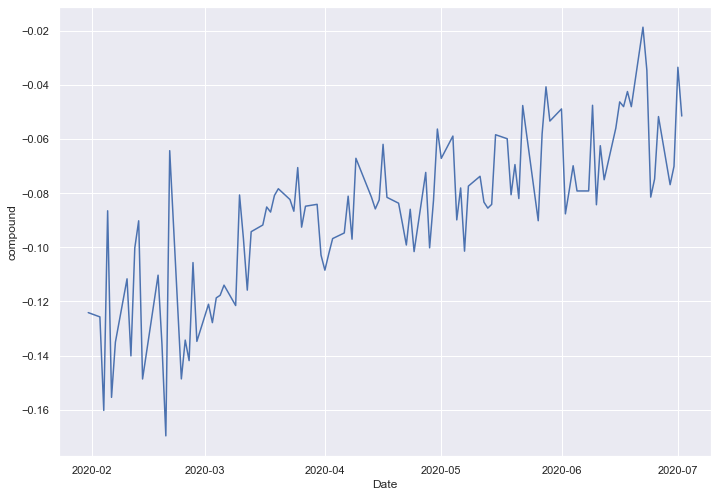

In [40]:
#plot average compound score
sns.lineplot(data=score_merged,x='Date',y='compound')

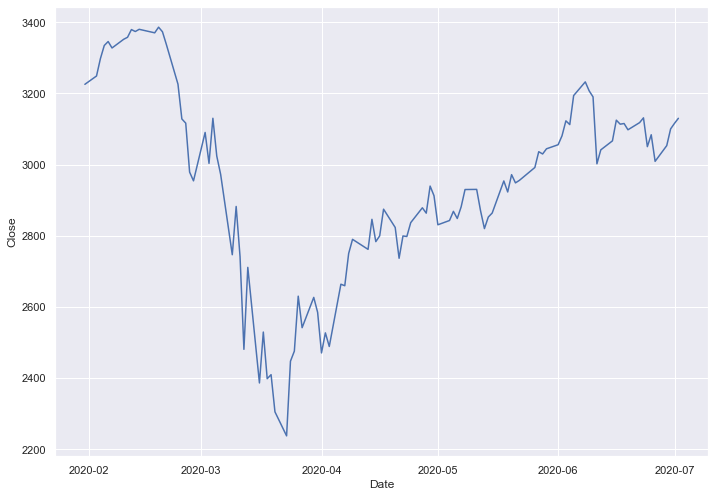

In [41]:
#plot of spx close price
sns.lineplot(data=score_merged,x='Date',y='Close')

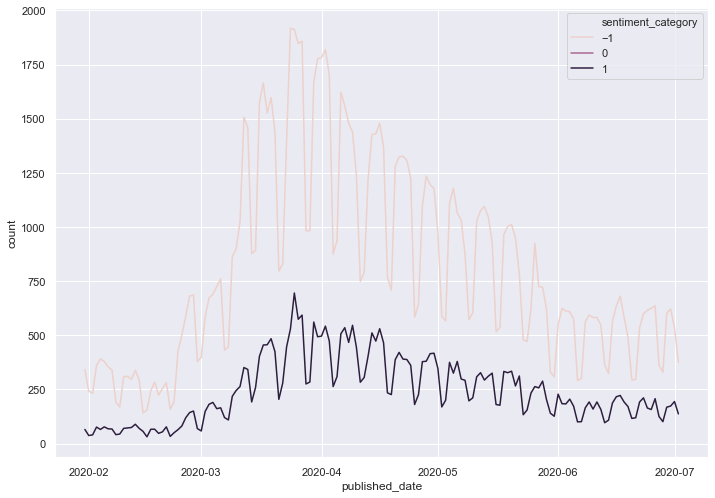

In [43]:
#count of positive and negative news
sns.lineplot(data=pos_neg,x='published_date',y='count', hue='sentiment_category')            

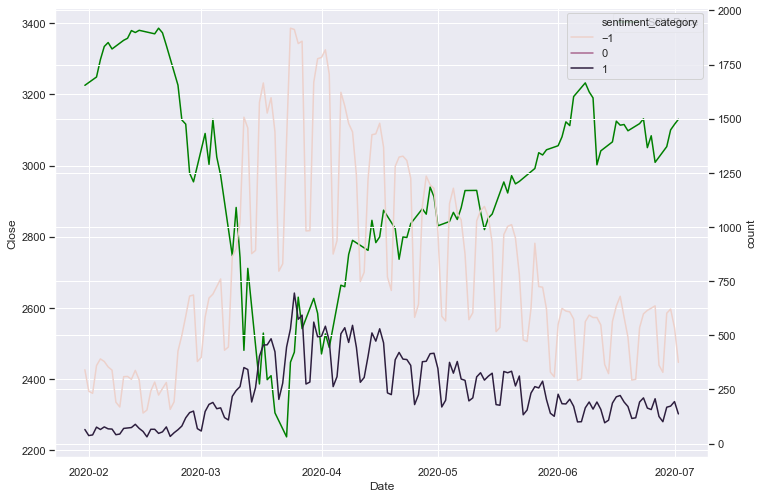

In [48]:
fig, ax = plt.subplots()
sns.lineplot(data=score_merged,x='Date',y='Close',color='green',label='SPX Price')
ax.legend()
ax2 = ax.twinx()
sns.lineplot(data=pos_neg,x='published_date',y='count',hue='sentiment_category')


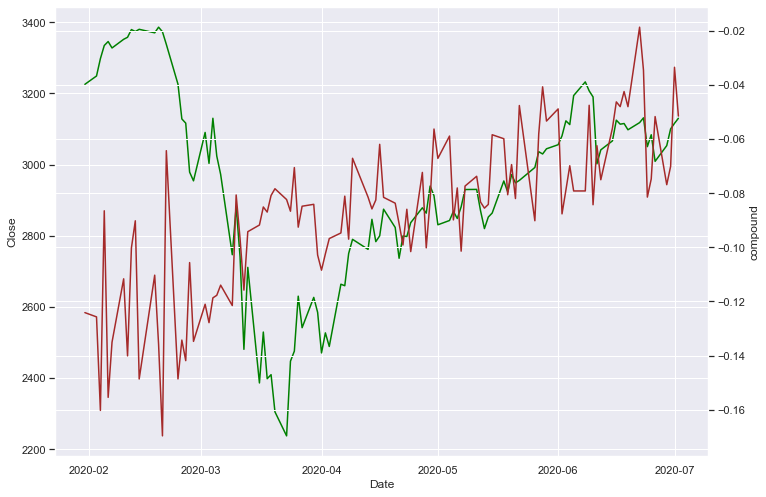

In [45]:
#plot average compound score

fig, ax = plt.subplots()
sns.lineplot(data=score_merged,x='Date',y='Close',color='green')
ax2 = ax.twinx()
sns.lineplot(data=score_merged,x='Date',y='compound',color='brown')

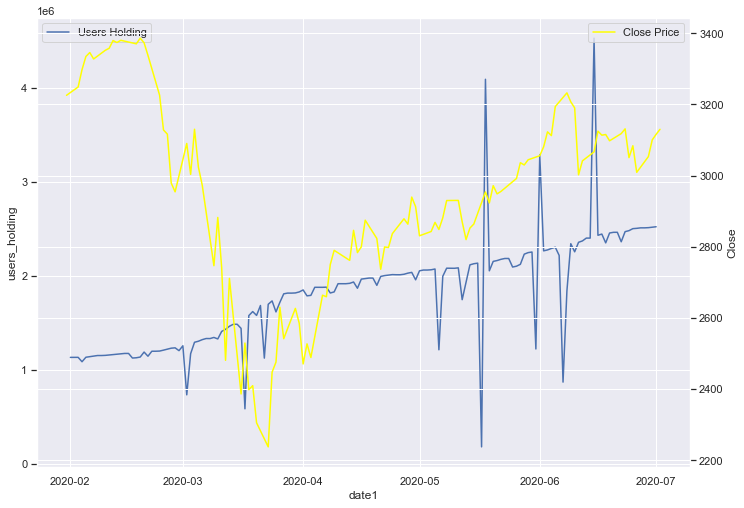

In [76]:
#plot user holding against spx price
fig, ax = plt.subplots()
sns.lineplot(data=ols_table, x='date1', y='users_holding',label='Users Holding')
ax2 = ax.twinx()
sns.lineplot(data=score_merged,x='Date',y='Close',label='Close Price',color='yellow') 
ax.legend()

In [86]:
#time series analysis
#difference the holding see if it's stationary
diff_holding=ols_table['users_holding'].diff(periods=1)
diff_holding

0          NaN
1        -30.0
2        450.0
3     -46745.0
4      47814.0
        ...   
147     5191.0
148      -29.0
149     2023.0
150     4389.0
151     5305.0
Name: users_holding, Length: 152, dtype: float64

In [91]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
p_value=adfuller(diff_holding[1:])[1]
p_value

1.3245497287394766e-09

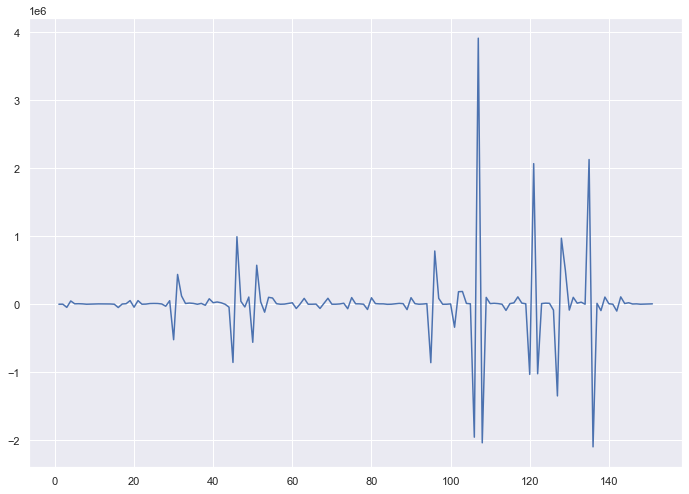

In [94]:
plt.plot(diff_holding)

In [95]:
#find order of AR and MA process
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = ARIMA(diff_holding, order=(i,0,j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic:    inf | order: None
